In [1]:
%matplotlib inline
from utils import *
from sklearn.model_selection import train_test_split
from deeplabv3p import preprocess_input
PATH = 'C://Users//jgolb//Desktop//datasets//'
image_size = (256, 256)


Using TensorFlow backend.


In [2]:
# build model
deeplab_seg = SegModel(PATH, image_size, use_coords = True)
deeplab_seg.set_batch_size(3)
deeplab_seg.set_num_epochs(4)

opt = SGD(lr=0.01, momentum = 0.9) # Adam()
deeplab_model = deeplab_seg.create_seg_model(opt, net='deeplabv3', load_weights = False, w=30, multi_gpu = False)

#deeplab_model.summary()

#### Create Generators

In [3]:
data_trn_gen_args_mask = dict(preprocessing_function = preprocess_mask,
                              horizontal_flip=True, rotation_range=45,
                              width_shift_range=0.01, 
                              height_shift_range=0.01,
                              zoom_range=0.2, 
                              validation_split = .2,
                              )

data_trn_gen_args_image = dict(preprocessing_function = preprocess_input,
                               horizontal_flip=True, rotation_range=45,
                               width_shift_range=0.01, 
                               height_shift_range=0.01,
                               zoom_range=0.2, 
                               validation_split = .2,
                               channel_shift_range = .2
                               )

data_val_gen_args_image = dict(preprocessing_function = preprocess_input, validation_split = .2)
data_val_gen_args_mask = dict(validation_split = .2)

train_generator = deeplab_seg.create_generators(data_trn_gen_args_image, data_trn_gen_args_mask, subset = 'training')
valid_generator = deeplab_seg.create_generators(data_val_gen_args_image, data_val_gen_args_mask, subset = 'validation')

Found 9624 images belonging to 1 classes.
Found 9624 images belonging to 1 classes.
Found 2405 images belonging to 1 classes.
Found 2405 images belonging to 1 classes.


['background', 'cat']


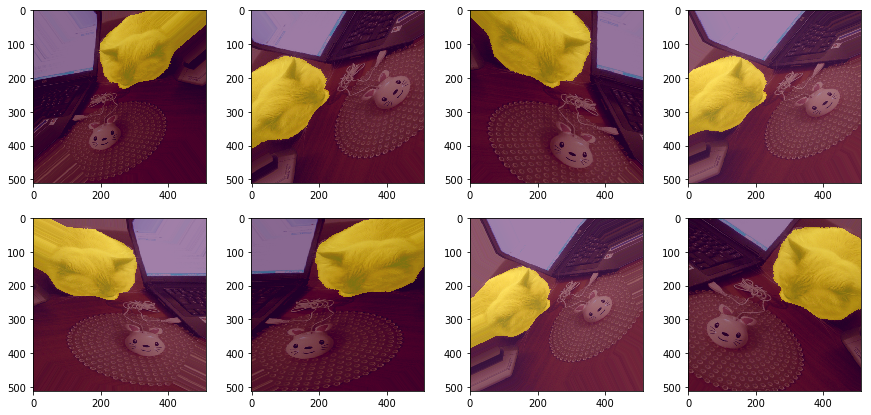

In [35]:
data_trn_gen_args_image['preprocessing_function'] = None

show_aug_data(train_generator, data_trn_gen_args_image, data_trn_gen_args_mask)

## Train Model

In [6]:
h = deeplab_seg.train_generator(deeplab_model, train_generator=train_generator, 
                                valid_generator = valid_generator, 
                                tf_board = True, mp = False)

In [6]:
# fit on an array
#h = deeplab_seg.train(deeplab_model, X_train[::50], y_train[::50], (X_valid[::50], y_valid[::50]), 
#                      tf_board = True, plot_train_process = True)

### Load Weights

In [5]:
deeplab_seg.load_weights(deeplab_model)

## Evaluate & Predict

1204/1204 [==============================] - 67s 55ms/step
mean acc: 0.044290
2406/2406 [==============================] - 128s 53ms/step
mean acc: 0.049970
test mean acc:  0.044290228935571205
validation mean acc:  0.04997033192927106


,IoU test,Objects,IoU valid
0,0.002185,background,0.002448
1,0.000000,aeroplane,0.000000
2,0.000000,bicycle,0.000000
3,0.000000,bird,0.000000
4,0.000000,boat,0.000000
5,0.000000,bottle,0.000000
6,0.000000,bus,0.000000
7,0.000000,car,0.000000
8,0.000000,cat,0.000000
9,0.000000,chair,0.000000


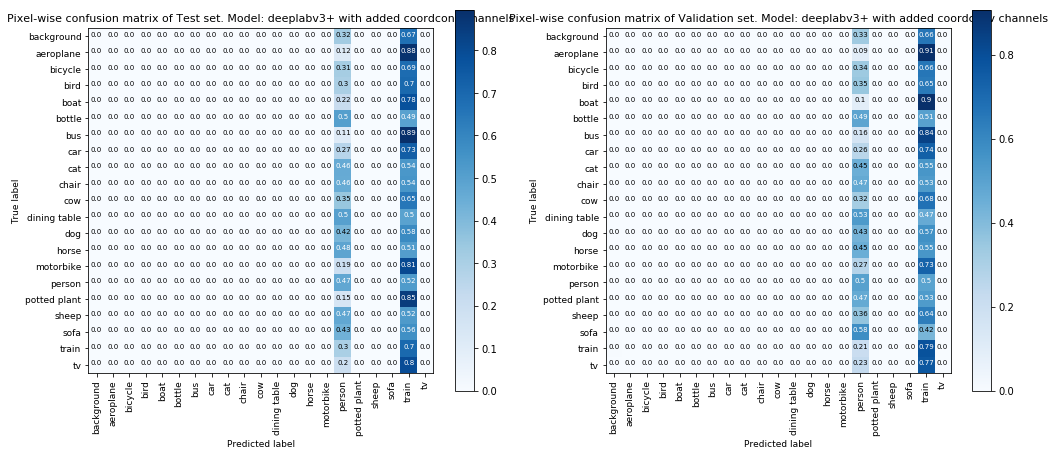

In [15]:
classes = [c for c in get_VOC2012_classes().values()]
y_preds = deeplab_model.predict(X_test, batch_size = deeplab_seg.batch_size, verbose=1)
df_test, conf_test, mean_acc_test = evaluate_model(y_preds, y_test, data_from = 'test')

y_preds = deeplab_model.predict(X_valid, batch_size = deeplab_seg.batch_size, verbose=1)
df_valid, conf_valid, mean_acc_valid = evaluate_model(y_preds, y_valid, data_from = 'valid')
df_test['IoU valid'] = df_valid['IoU valid']

if deeplab_seg.coords:
    model_name = 'deeplabv3+ with added coordconv channels'
else:
    model_name = 'deeplabv3+'

plt.figure(figsize=(17,7))
plt.subplot(121)
plot_confusion_matrix(conf_test, classes, normalize=True, 
                      title='Pixel-wise confusion matrix of Test set. Model: '+model_name)
plt.subplot(122)
plot_confusion_matrix(conf_valid, classes, normalize=True, 
                      title='Pixel-wise confusion matrix of Validation set. Model: '+model_name)

print('test mean acc: ', mean_acc_test)
print('validation mean acc: ', mean_acc_valid)
df_test

In [16]:
print(np.argmax(model.predict(np.expand_dims(X_valid[2], 0)),axis=-1)[0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [3]:
from deeplabv3p import Deeplabv3, preprocess_input
model = Deeplabv3(weights='pascal_voc', input_tensor=None, 
                  input_shape = (256,256,3), classes=21, 
                  backbone='mobilenetv2', OS=16, alpha=1, use_coordconv = False)

#model = load_model('seg_model.h5')
#model.summary()

In [20]:
y_preds = deeplab_model.predict(X_valid, batch_size = deeplab_seg.batch_size, verbose=1)
preds = np.argmax(y_preds, axis = -1)

2406/2406 [==============================] - 29s 12ms/step


In [50]:
classes[np.unique(preds[n])]

TypeError: unhashable type: 'numpy.ndarray'

In [51]:
classes = get_VOC2012_classes()

[classes[i] for i in np.unique(preds[n])]


['background', 'cat']

In [63]:
np.unique(preds[n])[1:]

array([5])

Text(0.5,1,"['boat']")

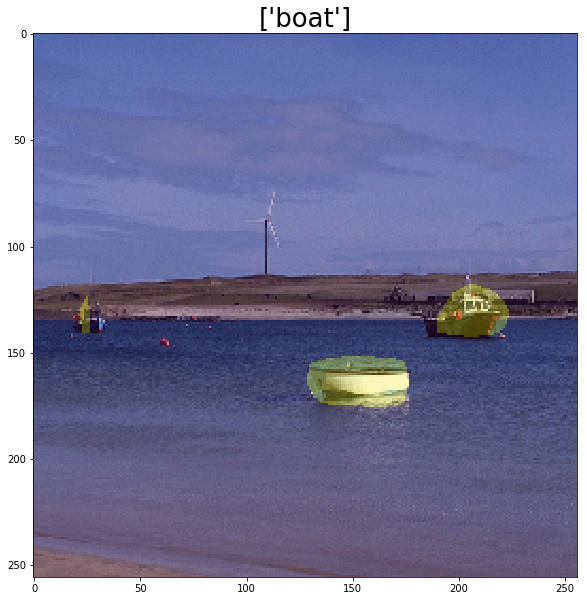

In [74]:
n=777
plt.figure(figsize=(10,10))
plt.imshow((X_valid[n]+1)*.5)
plt.imshow(preds[n].astype('uint8'), alpha=.3)
plt.title([classes[i] for i in np.unique(preds[n])[1:]], fontsize=26)

##### CoordConv Model

[ 0 16]
[ 0  5  9 11 15]


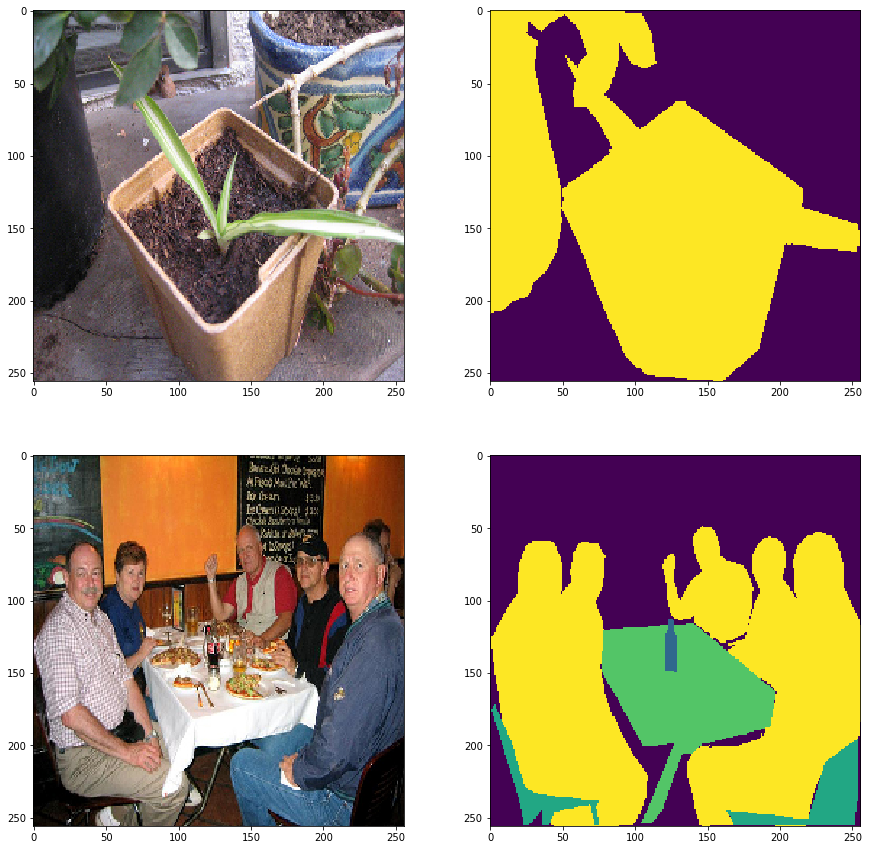

In [9]:
idx = np.random.randint(len(X))

plt.figure(figsize=(15,15))
plt.subplot(221),
plt.imshow((1+X[idx])*.5)
plt.subplot(222),


plt.imshow(y[idx][:,:,0]%255)
print(np.unique(y[idx][:,:,0]))
idx = np.random.randint(len(X))
plt.subplot(223),
plt.imshow((1+X[idx])*.5)
plt.subplot(224),
plt.imshow(y[idx][:,:,0]%255)
print(np.unique(y[idx][:,:,0]))